## Training Functions

### Plot graph

In [1]:
import nnfs
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data, vertical_data

nnfs.init()

def plot_prediction_performance(
    model: list | tuple,
    X, y,
    num_points: int = 100,
    device: str = 'cpu'
) -> None:
    """Plots the performance of the model in the spiral dataset with 3 categories"""
    def probabilities_to_rgb(probabilities_array):
        """ Maps an array of probabilities to RGB colors."""
        # Ensure that probabilities sum up to 1 for all data points
        if not torch.all(torch.isclose(torch.sum(probabilities_array, dim=1), torch.tensor(1.0).to(device))):
            raise ValueError("Probabilities must sum up to 1 for all data points.")
        
        # Map probabilities to RGB channels (0-255) for all data points
        r, g, b = (probabilities_array * 255).to(torch.int32).T
        
        # Return the RGB colors as a torch tensor
        return torch.stack((r, g, b), dim=1)

    # Create a meshgrid of points in the (-1,1)x(-1,1) space
    x_val = torch.linspace(-1, 1, num_points)
    y_val = torch.linspace(-1, 1, num_points)
    x_grid, y_grid = torch.meshgrid(x_val, y_val, indexing='xy')
    
    # Flatten the grids into 1D arrays
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()
    
    # Combine the flattened arrays into an Nx2 array
    XX_tuples = torch.stack((x_flat, y_flat), dim=1).to(device)
    
    # Perform a forward pass through the network
    input = XX_tuples
    for layer in model[:-1]:
        layer.forward(input)
        input = layer.output
    
    # Assumed last layer is a softmax activation + loss function
    # 'y_true' here is random since it will not be used
    # (only the output of the softmax is needed)
    model[-1].forward(input, y_true=torch.zeros(len(model[-2].output), dtype=torch.int32, device=device))
    probabilities_array = model[-1].output
    
    rgb_colors = probabilities_to_rgb(probabilities_array)
    probs_2d = rgb_colors.reshape(num_points, num_points, 3)
    
    # Assumed 3 categories - change this if different
    colors = ['r' if label == 0 else 'g' if label == 1 else 'b' for label in y]
    
    plt.imshow(probs_2d.cpu().numpy(), extent=(-1, 1, -1, 1), interpolation='bilinear')
    plt.scatter(X[:, 0].cpu(), -X[:, 1].cpu(), c=colors)
    plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

def plot_evolution(w_C, w_A, window_size=20):
    # smooth the data with a moving average
    w_C = np.convolve(w_C, np.ones(window_size), 'valid') / window_size
    w_A = np.convolve(w_A, np.ones(window_size), 'valid') / window_size
    
    time = np.linspace(0, 1, len(w_A))

    # Create segments for the line
    points = np.array([w_A, w_C]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a line collection
    norm = Normalize(vmin=time.min(), vmax=time.max())  # Normalize time values
    lc = LineCollection(segments, cmap="viridis", norm=norm)
    lc.set_array(time)  # Use time to color the line

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.add_collection(lc)
    ax.autoscale()  # Adjust axis limits
    ax.set_xlabel("W_A")
    ax.set_ylabel("W_C")
    ax.set_title("Final result: {:.3f}".format(w_C[-1]))
    ax.grid(True)

    # Add a colorbar to show time progression
    cbar = plt.colorbar(lc, ax=ax)
    cbar.set_label("Time")

    # plot initial and final points
    plt.scatter(w_A[0], w_C[0], c='r', label='Initial')
    plt.scatter(w_A[-1], w_C[-1], c='g', label='Final')

    plt.show()

### Loss

In [3]:
from abc import ABC, abstractmethod

class Loss(ABC):

    def __init__(self, device = 'cpu'):
        self.device = device
    
    @abstractmethod
    def forward(self, output, y):
        pass

    def calculate(self, output, y):
        """
        Return sample losses (mean)
         - output: output of the last layer of the network
         - y: ground truth
        """
        sample_losses = self.forward(output, y)
        data_loss = torch.mean(sample_losses)
        return data_loss

In [4]:
class Loss_CategoricalCrossentropy(Loss):
    
    def forward(self, output, y):
        output_clipped = torch.clip(output, 1e-7, 1-1e-7)
        correct_probs = output_clipped[range(len(output)), y]
        losses = -torch.log(correct_probs)
        return losses
    
    def backward(self, dvalues, y_true):
        y_true = np.eye(dvalues.shape[1])[y_true] # one-hot encoding
        dgrads = -y_true / dvalues # derivada de la función de pérdida
        self.dinputs = dgrads / dvalues.shape[0] # normalizamos el gradiente
        

In [5]:
class Loss_MSE(Loss):

    def __init__(self, device):
        super().__init__(device)

    def forward(self, inputs, y_true):
        self.inputs = inputs
        outputs = (inputs - y_true) ** 2
        clipped_outputs = torch.clip(outputs, 0, 100)
        return clipped_outputs
        
    def backward(self, dvalues, y_true):
        self.dinputs = 2 * (dvalues - y_true)


input = torch.tensor([2.2, 1.5])
Y_true = torch.tensor([2.0, 2.1])
loss = Loss_MSE('cpu')
loss_v = loss.forward(input, Y_true)
print(loss_v)
loss.backward(input, Y_true)
print(loss.dinputs)

tensor([0.0400, 0.3600])
tensor([ 0.4000, -1.2000])


### Dense Layer

In [6]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, bias=True, zeroes=False, device='cpu'):
        self.bias = bias
        if zeroes:
            self.weights = torch.zeros((n_inputs, n_neurons)).to(device)
        else:
            self.weights = 1e-2 * torch.randn((n_inputs, n_neurons)).to(device) # para ahorrarnos hacer la transpuesta
        if self.bias:
            self.biases = torch.zeros((1, n_neurons)).to(device)
    
    def forward(self, inputs):
        self.inputs = inputs
        if self.bias:
            self.output = inputs @ self.weights + self.biases
        else:
            self.output = inputs @ self.weights

    def backward(self, dvalues):
        self.dweights = self.inputs.T @ dvalues
        self.dinputs = dvalues @ self.weights.T
        if self.bias:
            self.dbiases = torch.sum(dvalues, dim=0, keepdims=True)

### RELU

In [7]:
# SOL EJ 20
class Activation_ReLU:

    def forward(self, inputs):
        self.output = torch.maximum(torch.tensor(0), inputs)
    
    def backward(self, dvalues):
        # copy the tensor
        self.dinputs = dvalues.clone()
        self.dinputs[self.output <= 0] = 0

### Softmax

In [8]:
class Activation_Softmax:

    def forward(self, inputs):
            inputs -= torch.max(inputs, dim=1, keepdims=True).values
            exp_values = torch.exp(inputs)
            norm_factor = torch.sum(exp_values, dim=1, keepdims=True)
            self.output = exp_values / norm_factor

    # Backward pass
    def backward(self, dvalues):
        # Create an uninitialized array with the same dimension as dvalues
        self.dinputs = torch.empty_like(dvalues)
        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array - use 'reshape'
            single_output = single_output.reshape(-1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = torch.diag(single_output) - torch.outer(single_output, single_output)
            # Calculate sample-wise gradient and add it to the array of sample gradients
            self.dinputs[index] = jacobian_matrix @ single_dvalues
    

In [9]:
class Activation_Softmax_Loss_CategoricalCrossentropy(Loss):

    def __init__(self, device):
        super().__init__(device)
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.forward(self.output, y_true)
        
    
    def backward(self, dvalues, y_true):
        y_true = torch.eye(dvalues.shape[1]).to(self.device)[y_true]

        # Derivada de la entropía cruzada: -SUM[y_true * 1/xi]
        # Derivada de la softmax: S_i * (1 - S_i) si i = j
        #                         -S_i * S_j si i != j
        # Regla de la cadena: dL/dxj = dL/dSj * dSj/dxj
        # Para i = j:
        # dL/dxj = - y_true * 1/S_i * S_i * (1 - S_i) = -y_true * (1 - S_i) = y_true * S_i - y_true
        # Para i != j:
        # dL/dxj = -SUM_i!=j[y_true * 1/S_i] * -S_i * S_j = SUM_i!=j[y_true * S_j]
        # Las combinamos
        # dL/dxj = SUM_i[y_true * S_j] - y_true = S_j - y_true

        self.dinputs = (dvalues - y_true) / dvalues.shape[0]


## SHD

In [10]:
class Optimizer_SHD:
    
    def __init__(self, layers, learning_rate_C=0.1, learning_rate_A=0.1, weight_decay_C = 0.2, weight_decay_A=0.2, t=[10, 1]):
        self.layers = layers
        self.learning_rate_C = learning_rate_C
        self.learning_rate_A = learning_rate_A
        self.weight_decay_C = weight_decay_C
        self.weight_decay_A = weight_decay_A
        self.t = t
        self.counter = 1
        if len(t) != len(layers):
            raise ValueError("The number of layers must be the same as the number of t values")

    def update_params(self):
        for layer, t in zip(self.layers, self.t):
            layer_C, layer_A = layer
            # update paramas of Auxiliary matrix -> always
            self.update_A(layer_C, layer_A)
  
            # update params of C matrix
            if self.counter % t == 0:
                update_index = torch.tensor((self.counter//t) % (layer_C.weights.shape[0] + int(layer_C.bias)), dtype=torch.int32)
                self.update_C(layer_C, layer_A, update_index)
        self.counter += 1

    
    def update_A(self, layer_C, layer_A):
        # update the weights of the Auxiliary matrix with the gradients of C and weight decay
        layer_A.weights += -self.learning_rate_A * (layer_C.dweights + self.weight_decay_A * layer_A.weights * torch.abs(layer_C.dweights))
        if layer_A.bias:
            layer_A.biases += -self.learning_rate_A * (layer_C.dbiases + self.weight_decay_A * layer_A.biases * torch.abs(layer_C.dbiases))

    def update_C(self, layer_C, layer_A, update_index):
        # partially update the weights of the C matrix with the values of A

        # # generate a tensor of random values lenght num_rows between 0 and 1
        # random_values = torch.rand(layer_C.weights.shape[0])
        # # for each value in the tensor, if it is greater than the mean_to_update, change it to 1, if not, to 0
        # update_index = torch.where(random_values < 1/self.t, torch.tensor(True), torch.tensor(False))


        # update the weights with the values of A
        if update_index < layer_C.weights.shape[0]:
            layer_C.weights[update_index] += self.learning_rate_C * (layer_A.weights[update_index] - self.weight_decay_C * layer_C.weights[update_index] * torch.abs(layer_A.weights[update_index]))

        # update the biases with the values of A
        else:
        #if layer_C.bias and torch.rand(1) < 1/self.t:
           layer_C.biases += self.learning_rate_C * (layer_A.biases - self.weight_decay_C * layer_C.biases * torch.abs(layer_A.biases))

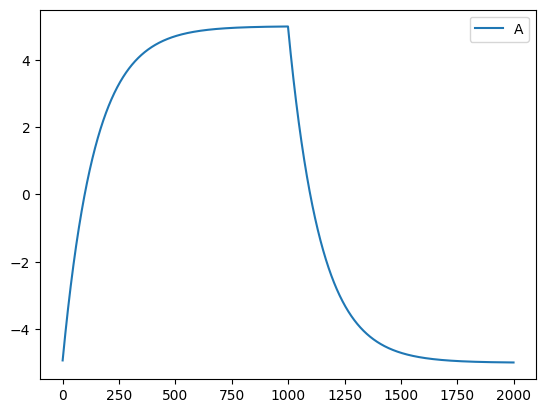

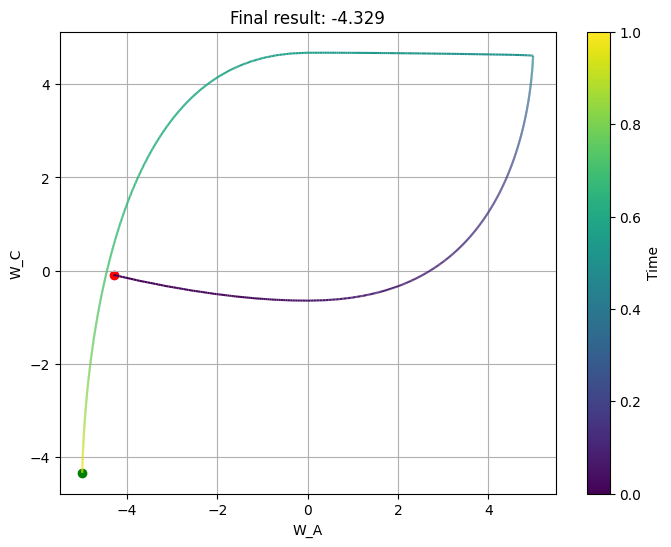

In [11]:
# testing asymmetry
dense1_C = Layer_Dense(1,1, zeroes=True, bias=False)
dense1_A = Layer_Dense(1,1, zeroes=True, bias=False)

optimizer = Optimizer_SHD([(dense1_C, dense1_A)], learning_rate_C=0.035, learning_rate_A=0.035, weight_decay_C=0.2, weight_decay_A=0.2, t=[10])

w_C = []
w_A = []

dense1_A.weights = torch.tensor([[-1/0.2]])
for i in range(2000):
    if i < 1000:
        dense1_C.forward(torch.tensor([[1.0]]))
        dense1_C.backward(torch.tensor([[-1.0]]))
    else:
        dense1_C.forward(torch.tensor([[1.0]]))
        dense1_C.backward(torch.tensor([[1.0]]))
    optimizer.update_params()
    w_C.append(dense1_C.weights.item())
    w_A.append(dense1_A.weights.item())

#plt.plot(w_C, label='C')
plt.plot(w_A, label='A')
plt.legend()
plot_evolution(w_C, w_A)

## Training

In [12]:
@torch.no_grad()
def training_run(X, y, epochs, opt_params, device='cpu'):
    #Implementa aquí la red neuronal
    dense1_C = Layer_Dense(2,64, device=device)
    dense1_A = Layer_Dense(2,64, zeroes=True, device=device)
    activation1 = Activation_ReLU()
    dense2_C = Layer_Dense(64,3, device=device)
    dense2_A = Layer_Dense(64,3, zeroes=True, device=device)
    loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy(device)
    optimizer = Optimizer_SHD([[dense1_C, dense1_A], [dense2_C, dense2_A]], **opt_params)

    loss = []
    accuracy = []
    # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
    neuron = 0
    weight = 0
    w_C = [dense2_C.weights[neuron][weight].item()]
    w_A = [dense2_A.weights[neuron][weight].item()]
    
    
    for _ in range(epochs):
        epoch_loss = []
        epoch_accuracy = []
        for x, y_true in zip(X, y):
            x = x.unsqueeze_(0)
            y_true = y_true.unsqueeze_(0)

            dense1_C.forward(x)
            activation1.forward(dense1_C.output)
            dense2_C.forward(activation1.output)
            l = loss_activation.calculate(dense2_C.output, y_true)

            # accuracy
            epoch_loss.append(l.item())
            correct_predictions = torch.sum(torch.argmax(loss_activation.output, axis=1) == y_true)
            epoch_accuracy.append(correct_predictions.item() / len(y_true))

            # backward pass
            loss_activation.backward(loss_activation.output, y_true)
            dense2_C.backward(loss_activation.dinputs)
            activation1.backward(dense2_C.dinputs)
            dense1_C.backward(activation1.dinputs)

            # update params
            optimizer.update_params()

            # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
            w_C.append(dense2_C.weights[neuron][weight].item())
            w_A.append(dense2_A.weights[neuron][weight].item())


        loss.append(np.mean(epoch_loss))
        accuracy.append(np.mean(epoch_accuracy))

    trained_model = [dense1_C, activation1, dense2_C, loss_activation]

    return loss, accuracy, trained_model, w_C, w_A


@torch.no_grad()
def training_run_batched(X, y, epochs, opt_params, device='cpu'):
    #Implementa aquí la red neuronal
    dense1_C = Layer_Dense(2,64, device=device)
    dense1_A = Layer_Dense(2,64, zeroes=True, device=device)
    activation1 = Activation_ReLU()
    dense2_C = Layer_Dense(64,3, device=device)
    dense2_A = Layer_Dense(64,3, zeroes=True, device=device)
    loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy(device)
    optimizer = Optimizer_SHD([[dense1_C, dense1_A], [dense2_C, dense2_A]], **opt_params)

    loss = []
    accuracy = []
    # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
    neuron = 0
    weight = 0
    w_C = [dense2_C.weights[neuron][weight].item()]
    w_A = [dense2_A.weights[neuron][weight].item()]
    
    
    for _ in range(epochs):
        x = X
        y_true = y

        dense1_C.forward(x)
        activation1.forward(dense1_C.output)
        dense2_C.forward(activation1.output)
        l = loss_activation.calculate(dense2_C.output, y_true)

        # accuracy
        loss.append(l.item())
        correct_predictions = torch.sum(torch.argmax(loss_activation.output, axis=1) == y_true)
        accuracy.append(correct_predictions.item() / len(y_true))

        # backward pass
        loss_activation.backward(loss_activation.output, y_true)
        dense2_C.backward(loss_activation.dinputs)
        activation1.backward(dense2_C.dinputs)
        dense1_C.backward(activation1.dinputs)

        # update params
        optimizer.update_params()

        # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
        w_C.append(dense2_C.weights[neuron][weight].item())
        w_A.append(dense2_A.weights[neuron][weight].item())


    trained_model = [dense1_C, activation1, dense2_C, loss_activation]

    return loss, accuracy, trained_model, w_C, w_A


### Spiral_data

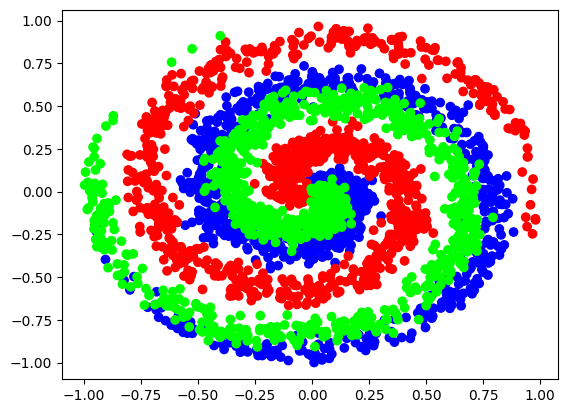

In [13]:
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)

# plot spiral data
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='brg')

In [13]:
# grid search for hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=100, classes=3)
X = torch.tensor(X_np, dtype=torch.float32, requires_grad=False).to(device)
y = torch.tensor(y_np, dtype=torch.int32, requires_grad=False).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

# grid search
learning_rate_C = [1e-1, 5e-1, 1]
learning_rate_A = [1e-1, 5e-1, 1]
t = [[1,1], [5,1]]

best_loss = float('inf')
best_accuracy = 0

for lr_C in learning_rate_C:
    for lr_A in learning_rate_A:
            for t_ in t:
                opt_params = {'learning_rate_C': lr_C, 'learning_rate_A': lr_A, 't': t_}
                loss, accuracy, model, _, _ = training_run_batched(X, y, 10000, opt_params=opt_params, device=device)
                print(f'Loss: {loss[-1]:.2f}, accuracy: {accuracy[-1]:.2f} for params: {opt_params}')
                if loss[-1] < best_loss:
                    best_loss = loss[-1]
                    best_accuracy = accuracy[-1]
                    best_params = opt_params

print(f'Best loss: {best_loss}, best accuracy: {best_accuracy} for params: {best_params}')

Loss: 0.49, accuracy: 0.79 for params: {'learning_rate_C': 0.1, 'learning_rate_A': 0.1, 't': [1, 1]}
Loss: 0.50, accuracy: 0.78 for params: {'learning_rate_C': 0.1, 'learning_rate_A': 0.1, 't': [5, 1]}
Loss: 0.32, accuracy: 0.86 for params: {'learning_rate_C': 0.1, 'learning_rate_A': 0.5, 't': [1, 1]}
Loss: 0.45, accuracy: 0.80 for params: {'learning_rate_C': 0.1, 'learning_rate_A': 0.5, 't': [5, 1]}
Loss: 0.32, accuracy: 0.89 for params: {'learning_rate_C': 0.1, 'learning_rate_A': 1, 't': [1, 1]}
Loss: 0.64, accuracy: 0.67 for params: {'learning_rate_C': 0.1, 'learning_rate_A': 1, 't': [5, 1]}
Loss: 0.68, accuracy: 0.61 for params: {'learning_rate_C': 0.5, 'learning_rate_A': 0.1, 't': [1, 1]}
Loss: 0.75, accuracy: 0.59 for params: {'learning_rate_C': 0.5, 'learning_rate_A': 0.1, 't': [5, 1]}
Loss: 1.08, accuracy: 0.42 for params: {'learning_rate_C': 0.5, 'learning_rate_A': 0.5, 't': [1, 1]}
Loss: 1.35, accuracy: 0.37 for params: {'learning_rate_C': 0.5, 'learning_rate_A': 0.5, 't': [5

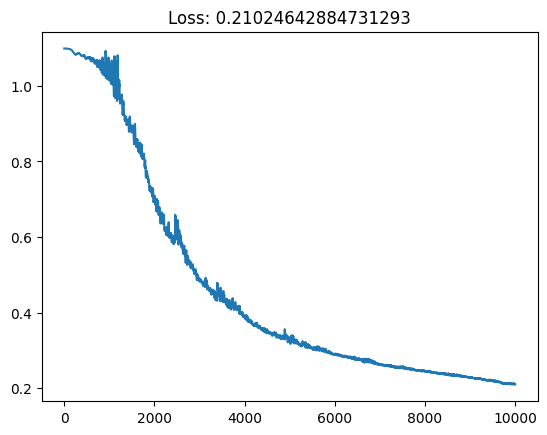

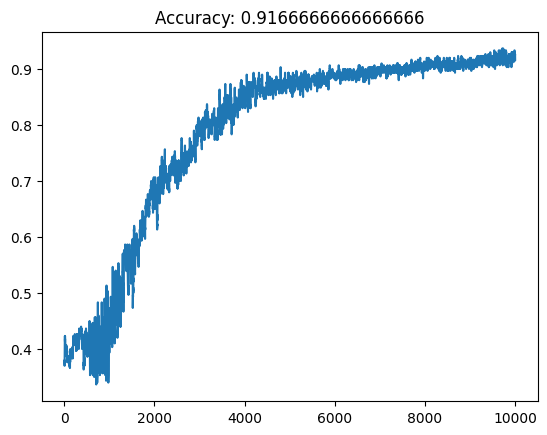

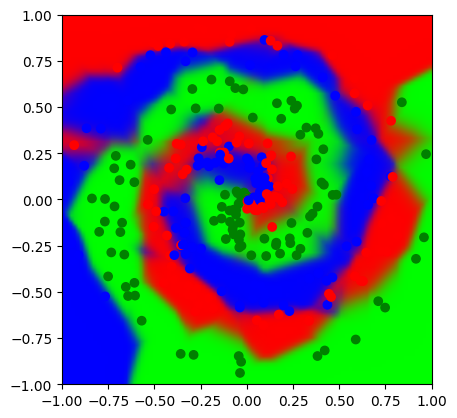

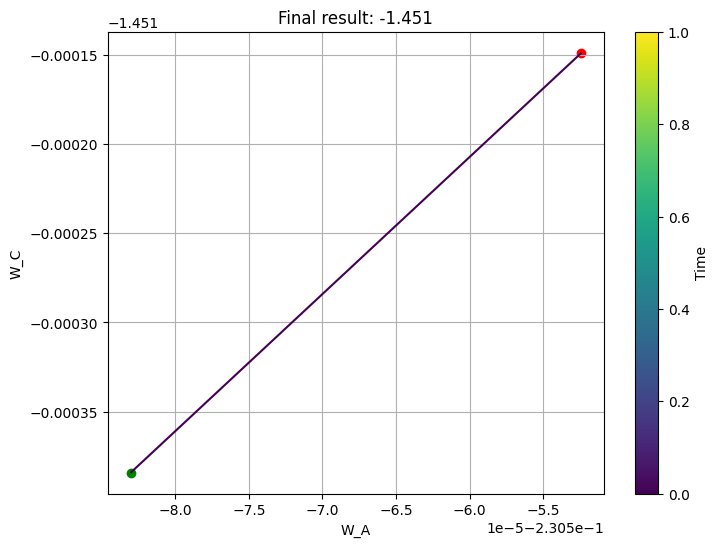

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=100, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int32).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

opt_params = {'learning_rate_C': 0.1, 'learning_rate_A': 1, 't': [1,1]}

loss, accuracy, model, w_C, w_A = training_run_batched(X, y, 10000, opt_params=opt_params, device=device)

plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)

plot_evolution(w_C, w_A, window_size=10000)

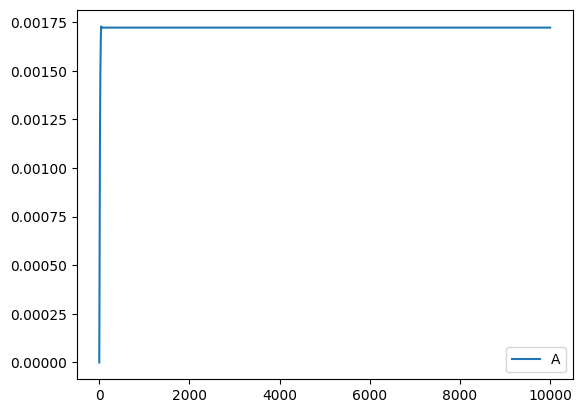

In [83]:
plt.plot(w_A, label='A')
#plt.plot(w_C, label='C')
plt.legend()

### Vertical_data

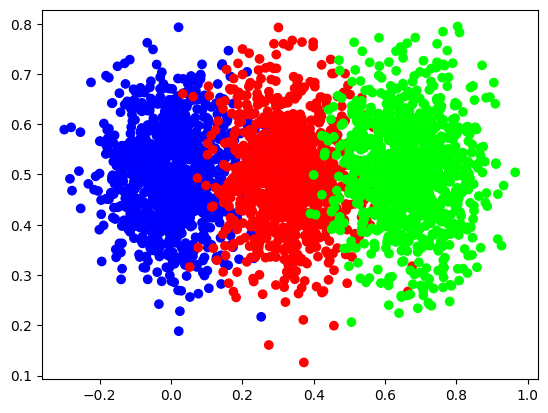

In [123]:
X_np, y_np = vertical_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int32).to(device)

# plot the spiral dataset
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='brg')

In [ ]:
# grid search for hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = vertical_data(samples=100, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int32).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

# grid search
learning_rate_C = [1e-3, 1e-2, 1e-1]
learning_rate_A = [1e-3, 1e-2, 1e-1]
t = [[5, 1]]

best_loss = float('inf')
best_accuracy = 0

for lr_C in learning_rate_C:
    for lr_A in learning_rate_A:
            for t_ in t:
                opt_params = {'learning_rate_C': lr_C, 'learning_rate_A': lr_A, 't': t_}
                loss, accuracy, model, _, _ = training_run(X, y, 20, opt_params=opt_params, device=device)
                print(f'Loss: {loss[-1]:.2f}, accuracy: {accuracy[-1]:.2f} for params: {opt_params}')
                if loss[-1] < best_loss:
                    best_loss = loss[-1]
                    best_accuracy = accuracy[-1]
                    best_params = opt_params

print(f'Best loss: {best_loss}, best accuracy: {best_accuracy} for params: {best_params}')

Loss: 1.10, accuracy: 0.33 for params: {'learning_rate_C': 0.001, 'learning_rate_A': 0.001, 't': 1}
Loss: 1.10, accuracy: 0.56 for params: {'learning_rate_C': 0.001, 'learning_rate_A': 0.001, 't': 5}
Loss: 1.09, accuracy: 0.91 for params: {'learning_rate_C': 0.001, 'learning_rate_A': 0.01, 't': 1}
Loss: 1.10, accuracy: 0.62 for params: {'learning_rate_C': 0.001, 'learning_rate_A': 0.01, 't': 5}
Loss: 0.58, accuracy: 0.83 for params: {'learning_rate_C': 0.001, 'learning_rate_A': 0.1, 't': 1}
Loss: 1.09, accuracy: 0.87 for params: {'learning_rate_C': 0.001, 'learning_rate_A': 0.1, 't': 5}
Loss: 1.09, accuracy: 0.33 for params: {'learning_rate_C': 0.01, 'learning_rate_A': 0.001, 't': 1}
Loss: 1.10, accuracy: 0.33 for params: {'learning_rate_C': 0.01, 'learning_rate_A': 0.001, 't': 5}
Loss: 0.33, accuracy: 0.92 for params: {'learning_rate_C': 0.01, 'learning_rate_A': 0.01, 't': 1}
Loss: 1.07, accuracy: 0.59 for params: {'learning_rate_C': 0.01, 'learning_rate_A': 0.01, 't': 5}
Loss: 0.86, 

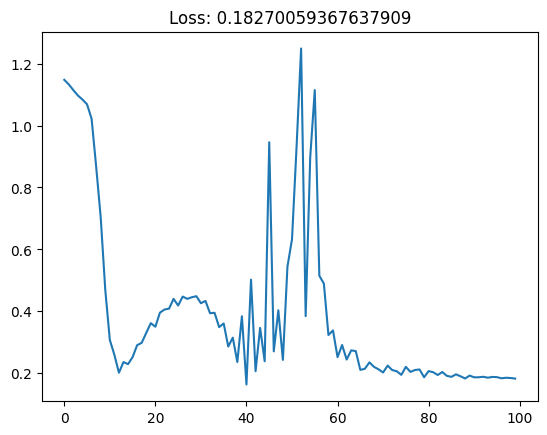

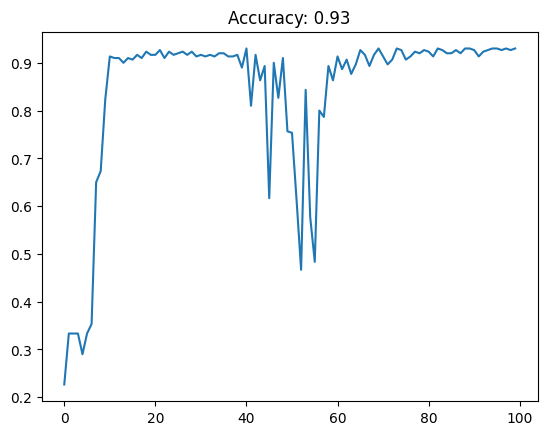

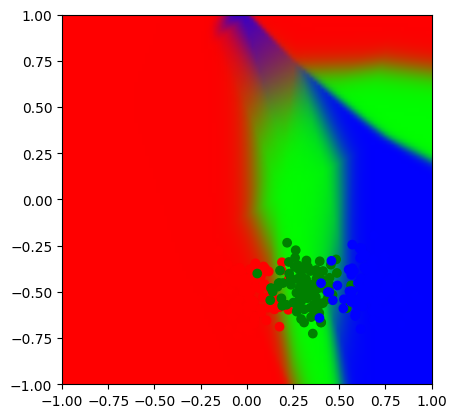

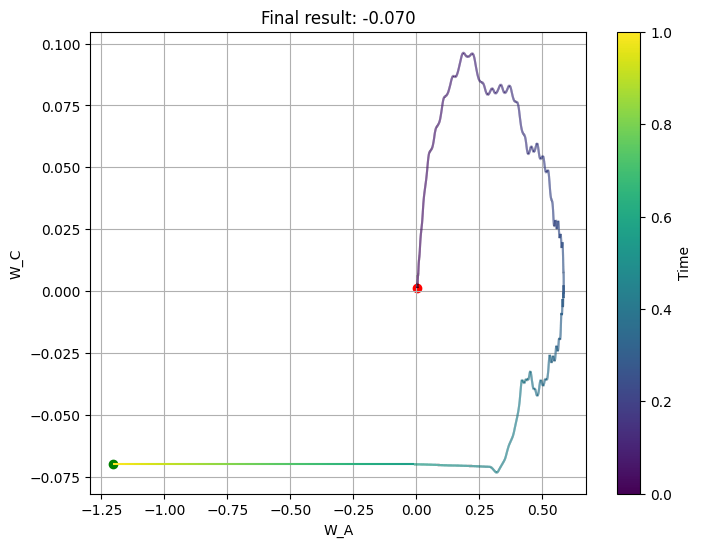

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = vertical_data(samples=100, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int32).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

opt_params = {'learning_rate_C': 0.1, 'learning_rate_A': 0.01, 't': [5,1]}

loss, accuracy, model, w_C, w_A = training_run(X, y, 100, opt_params=opt_params, device=device)

plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)
plot_evolution(w_A, w_C, window_size=1000)

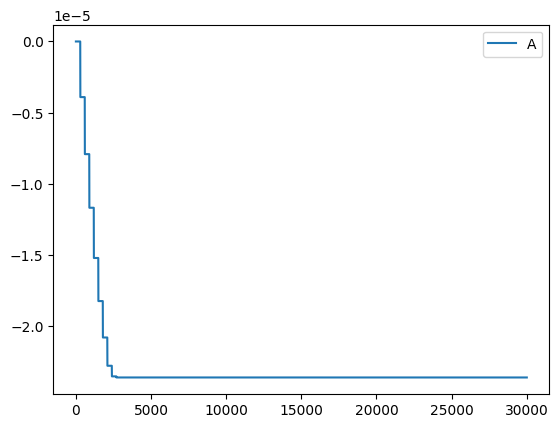

In [139]:
plt.plot(w_A, label='A')
#plt.plot(w_C, label='C')
plt.legend()

### Synthetic data -> regression

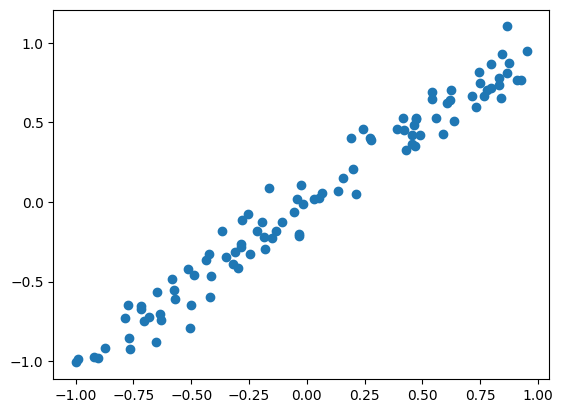

In [125]:
# generate a 100 point dataset for a linear regression problem with 1 feature
def generate_linear_regression_data(num_points=100):
    X = np.random.uniform(-1, 1, (num_points, 1))
    y = 1 * X + np.random.normal(0, 0.1, (num_points, 1))
    return X, y

# plot the data
X, y = generate_linear_regression_data(100)
plt.scatter(X, y)

In [126]:
def training_run_linear(X, y, epochs, opt_params, device='cpu'):  
    dense1_C = Layer_Dense(1,1, bias=False, device=device)
    dense1_A = Layer_Dense(1,1, bias=False, zeroes=True, device=device)
    optimizer = Optimizer_SHD([[dense1_C, dense1_A]], **opt_params)
    loss_func = Loss_MSE(device)

    loss = []

    w_C = [dense1_C.weights.item()]
    w_A = [dense1_A.weights.item()]

    for i in range(epochs):
        # foward pass
        epoch_loss = []
        for x, y_true in zip(X, y):
            x = x.unsqueeze_(0)
            y_true = y_true.unsqueeze_(0)

            dense1_C.forward(x)
            l = loss_func.calculate(dense1_C.output, y_true)

            epoch_loss.append(l.item())

            # backward pass
            loss_func.backward(loss_func.inputs, y_true)
            dense1_C.backward(loss_func.dinputs)

            # update params
            optimizer.update_params()
            w_C.append(dense1_C.weights.item())
            w_A.append(dense1_A.weights.item())

        loss.append(np.mean(epoch_loss))

    trained_model = [dense1_C, loss_func]

    return loss, trained_model, w_C, w_A

In [128]:
# grid search for hyperparameters
device = 'cpu'
X_np, y_np = generate_linear_regression_data(100)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.float32).to(device)

# grid search
learning_rate_C = [1e-3, 5e-3, 1e-2]
learning_rate_A = [1e-2, 1e-1]
t = [[5], [10], [20]]

best_loss = float('inf')

for lr_C in learning_rate_C:
    for lr_A in learning_rate_A:
            for t_ in t:
                opt_params = {'learning_rate_C': lr_C, 'learning_rate_A': lr_A, 't': t_}
                loss, model, _, _ = training_run_linear(X, y, 20, opt_params=opt_params, device=device)
                print(f'Loss: {loss[-1]:.2f} for params: {opt_params}')
                if loss[-1] < best_loss:
                    best_loss = loss[-1]
                    best_params = opt_params

print(f'Best loss: {best_loss} for params: {best_params}')

Loss: 0.01 for params: {'learning_rate_C': 0.001, 'learning_rate_A': 0.01, 't': [5]}
Loss: 0.07 for params: {'learning_rate_C': 0.001, 'learning_rate_A': 0.01, 't': [10]}
Loss: 0.18 for params: {'learning_rate_C': 0.001, 'learning_rate_A': 0.01, 't': [20]}
Loss: 0.01 for params: {'learning_rate_C': 0.001, 'learning_rate_A': 0.1, 't': [5]}
Loss: 0.02 for params: {'learning_rate_C': 0.001, 'learning_rate_A': 0.1, 't': [10]}
Loss: 0.12 for params: {'learning_rate_C': 0.001, 'learning_rate_A': 0.1, 't': [20]}
Loss: 0.01 for params: {'learning_rate_C': 0.005, 'learning_rate_A': 0.01, 't': [5]}
Loss: 0.12 for params: {'learning_rate_C': 0.005, 'learning_rate_A': 0.01, 't': [10]}
Loss: 0.03 for params: {'learning_rate_C': 0.005, 'learning_rate_A': 0.01, 't': [20]}
Loss: 0.01 for params: {'learning_rate_C': 0.005, 'learning_rate_A': 0.1, 't': [5]}
Loss: 0.01 for params: {'learning_rate_C': 0.005, 'learning_rate_A': 0.1, 't': [10]}
Loss: 0.01 for params: {'learning_rate_C': 0.005, 'learning_rat

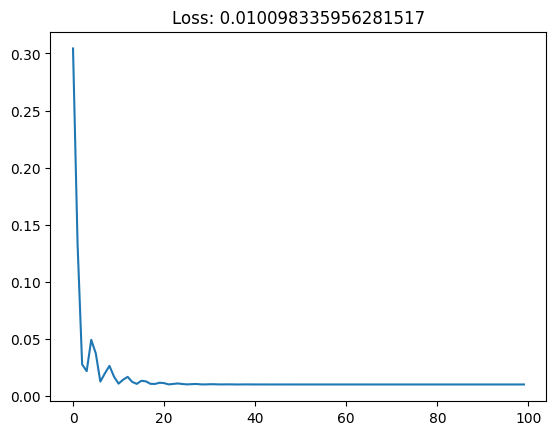

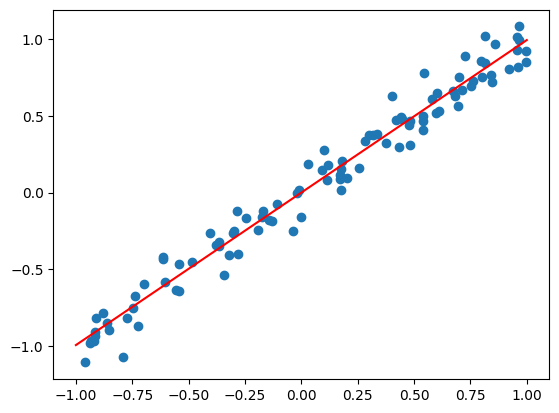

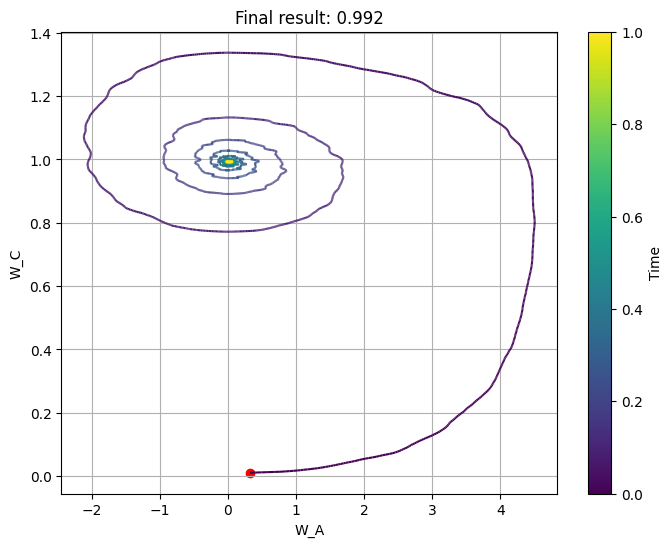

In [129]:
device = 'cpu'
X_np, y_np = generate_linear_regression_data(100)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.float32).to(device)
opt_params = {'learning_rate_C': 5e-3, 
              'learning_rate_A': 1e-1,
              'weight_decay_C': 0.2, 
              'weight_decay_A': 0.2, 
              't': [5]}

loss, model, w_C, w_A = training_run_linear(X, y, 100, opt_params=opt_params, device=device)


plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

# plot the linear regression line over the data
dense1_C = model[0]
X_line = torch.tensor([[-1], [1]], dtype=torch.float32).to(device)
dense1_C.forward(X_line)
y_line = dense1_C.output.detach().cpu().numpy()
plt.scatter(X_np, y_np)
plt.plot([-1, 1], y_line, c='r')
plt.show()

plot_evolution(w_C, w_A, window_size=10)

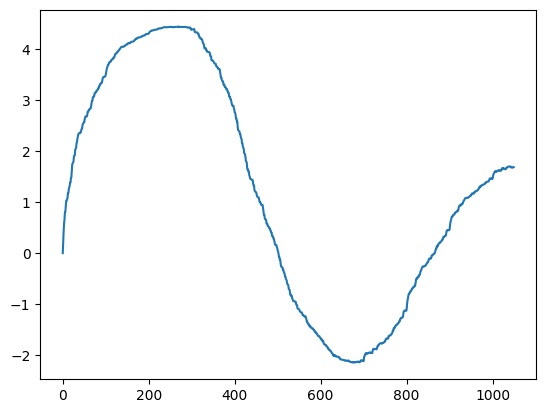

In [113]:
# plot the volution of W_a
plt.plot(w_A[:1050])

## Ejercicio 26: Optimizador — Descenso del gradiente

Programa una clase llamada ```Optimizer_SGD``` que implemente el optimizador de descenso de gradiente. Pasa a su constructor un parámetro ```learning_rate``` por defecto de $1$. Dicha clase deberá contener un único método llamado ```update_params(layer)``` al que se le pase una capa y aplique sus correspondientes gradientes a la actualización de sus parámetros.

In [13]:
# SOL EJ 26
class Optimizer_SGD:
    
    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate
    
    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases

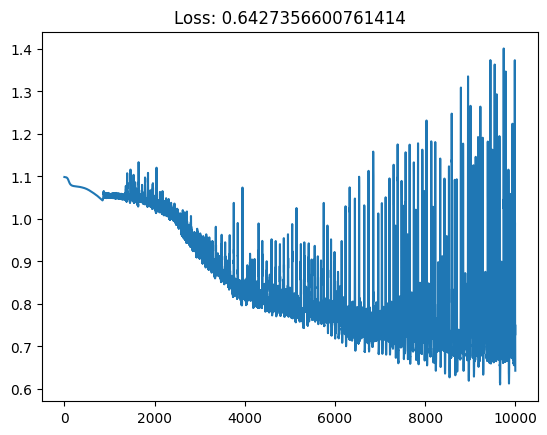

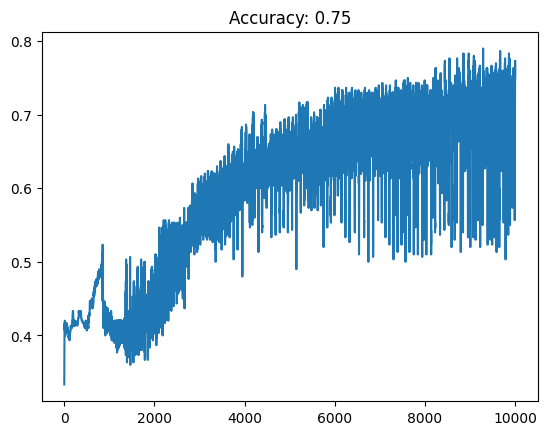

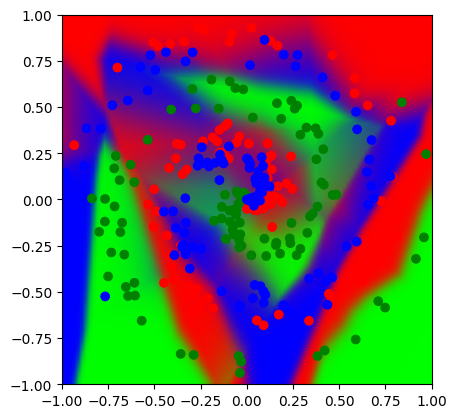

In [14]:
#SOL 27
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=100, classes=3)
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.int32)

#Implementa aquí la red neuronal
dense1 = Layer_Dense(2,64, device=device)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3, device=device)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy(device=device)
optimizer = Optimizer_SGD()

# listas para almacenar la evolución de la loss y la precisión
loss = []
accuracy = []

# entrenamiento aleatorio
for _ in range(10000):
    # foward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    l = loss_activation.calculate(dense2.output, y)

    # calculamos la loss y la precisión
    loss.append(l)
    correct_predictions = torch.sum(torch.argmax(loss_activation.output, axis=1) == y)
    accuracy.append(correct_predictions / len(y))

    # backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # actualizamos los parametros
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

# mostramos la evolución de la loss y la precisión
plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()


#Este código a continuación te ayudará a visualizar los resultados de la red (asegúrate que el la lista 'model' contiene los mismo nombres para las distintas capas, y si no es así actualiza dicha variable con el naming usado)
model = [dense1, activation1, dense2, loss_activation]
num_points = 100
plot_prediction_performance(model, X, y, num_points)

# los resulltados son buenos, pero no parecen muy estables. Con el paso del tiempo,
# parece que hay cambios demasiado bruscos en la loss y la precisión.
# Probablemente ayede si implementamos un learning rate decay.

## Ejercicio 29: *Learning rate decay*

 - **29.a** Extiende la implementación de la clase ```Optimizer_SGD``` que hiciste en el ejercicio 26 para que incluya un mecanismo que aplique el decaimiento de la tasa de aprendizaje. Ahora, además del argumento ```learning_rate```, el constructor de la clase recibirá el ```decay```. En dicho constructor, inicializa también dos variables adicionales: ```self.current_learning_rate``` (para ir almacenando el *learning rate* en sucesivas iteraciones) y ```self.iterations``` (para ir almacenando el número de iteraciones). Actualiza el método ```update_params``` e implementa dos nuevos métodos: 
   - ```pre_update_params(self)```: responsable de actualizar ```self.current_learning_rate```. Está pensado para será ejecutado justo antes de la llamada a ```update_params```.
   - ```post_update_params(self)```: responsable de actualizar ```self.iterations```. Está pensado para será ejecutado justo después de la llamada a ```update_params```.

In [ ]:
# SOL EJ 29a
class Optimizer_SGD:
    
    def __init__(self, learning_rate=1.0, decay=0.0):
        self.learning_rate = learning_rate
        self.decay = decay
        self.current_learning_rate = learning_rate
        self.iterations = 0
    
    def update_params(self, layer):
        layer.weights += -self.current_learning_rate * layer.dweights
        layer.biases += -self.current_learning_rate * layer.dbiases

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate / (1 + self.decay * self.iterations)

    def post_update_params(self):
        self.iterations += 1

  - **29.b** Partiendo del código al que llegaste en el ejercicio 27, prueba el mecanismo de *Learning rate decay* que acabas de implementar. Experimenta con un *decay* de $10^{-2}$ y de $10^{-3}$ ¿Se mejoran los resultados en comparación con los que obtuviste en el ejercicio 27? Recuerda visiualizar los resultados como se explica en el ejercicio 27.

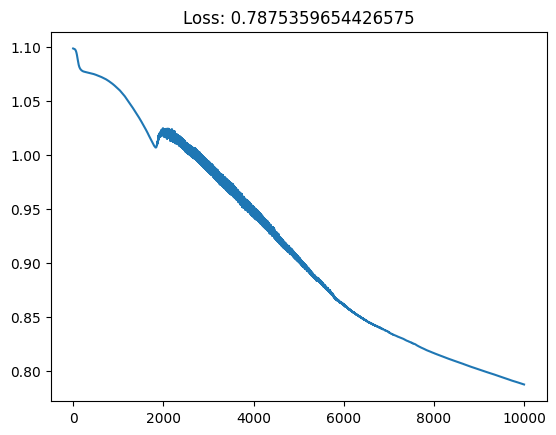

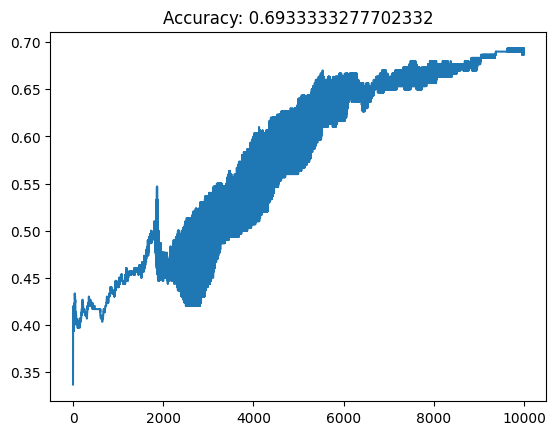

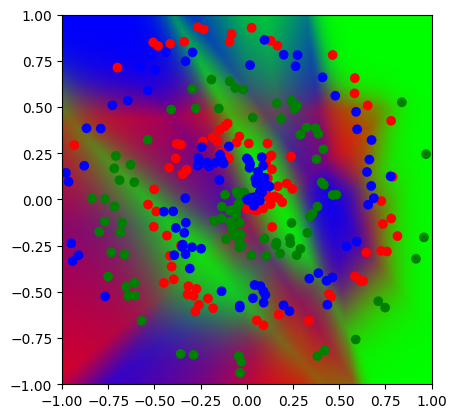

In [ ]:
#SOL 29b

nnfs.init()
X, y = spiral_data(samples=100, classes=3)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int32)

#Implementa aquí la red neuronal
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_SGD(learning_rate=1, decay=1e-3)

# listas para almacenar la evolución de la loss y la precisión
loss = []
accuracy = []

# entrenamiento aleatorio
for _ in range(10000):
    # foward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    l = loss_activation.calculate(dense2.output, y)

    # calculamos la loss y la precisión
    loss.append(l)
    correct_predictions = torch.sum(torch.argmax(loss_activation.output, dim=1) == y)
    accuracy.append(correct_predictions / len(y))

    # backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # actualizamos los parametros
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

# mostramos la evolución de la loss y la precisión
plt.plot(loss)
# two decimal places
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()


#Este código a continuación te ayudará a visualizar los resultados de la red (asegúrate que el la lista 'model' contiene los mismo nombres para las distintas capas, y si no es así actualiza dicha variable con el naming usado)
model = [dense1, activation1, dense2, loss_activation]
num_points = 100
plot_prediction_performance(model, X, y, num_points)

# la evolución de la loss y la precisión es un poco más estable, pero no demasiado. 
# Con 1e-2 deja de aprender demasiado pronto, 1e-3 funciona mejor y los resultados son
# mejores que en el ejercicio anterior, ademas de mucho más estables.

## Ejercicio 30: Descenso de gradiente con momentum

 - **30.a** Extiende la implementación de la clase ```Optimizer_SGD``` que hiciste en el ejercicio 29 para que incluya el mecanismo de *momentum*. Sigue la siguiente plantilla de desarrollo:

In [ ]:
# SOL EJ 30a -> completa las líneas con ######

# SGD optimizer con momentum
class Optimizer_SGD:

    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def pre_update_params(self):
        ## SIN CAMBIOS - COPIA LA IMPLEMENTACIÓN QUE HICISTE EN EL EJERCICIO 29
        self.current_learning_rate = self.learning_rate / (1 + self.decay * self.iterations)

    def update_params(self, layer):

        # If we use momentum, create momentum arrays if they don't exist. Initialized at zeros
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = torch.zeros_like(layer.weights)
                layer.bias_momentums = torch.zeros_like(layer.biases)

            # Compute weight and bias updates with momentum
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Compute weight and bias updates without momentum
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        # Update weights and biases using either vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

        
    def post_update_params(self):
        ## SIN CAMBIOS - COPIA LA IMPLEMENTACIÓN QUE HICISTE EN EL EJERCICIO 29
        self.iterations += 1

  - **30.b** Partiendo del código al que llegaste en el ejercicio 29, prueba el mecanismo de momentum que acabas de implementar. Probar con un *decay* de $10^{-3}$ y un *momentum* de $0.5$ y luego de $0.9$. ¿Se mejoran los resultados en comparación con los que obtuviste en el ejercicio 29? Recuerda visiualizar los resultados como se explica en el ejercicio 27.

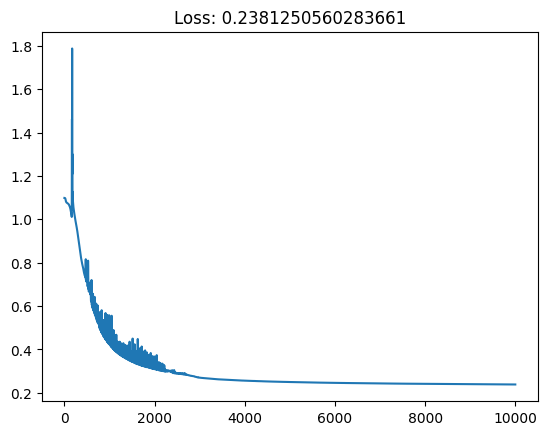

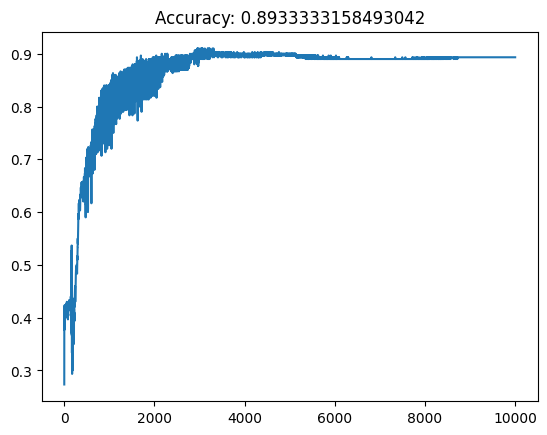

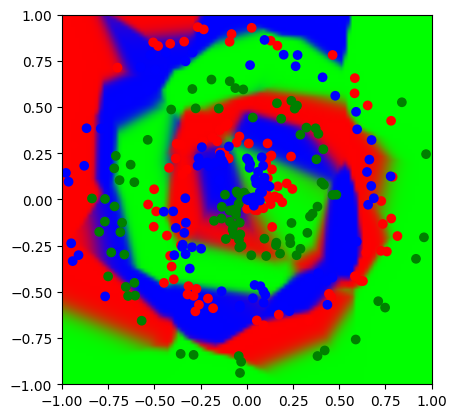

In [ ]:
# SOL EJ 30b

nnfs.init()
X, y = spiral_data(samples=100, classes=3)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int32)

#Implementa aquí la red neuronal
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_SGD(decay=1e-3, momentum = 0.88)

# listas para almacenar la evolución de la loss y la precisión
loss = []
accuracy = []

# entrenamiento aleatorio
for _ in range(10000):
    # foward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    l = loss_activation.calculate(dense2.output, y)

    # calculamos la loss y la precisión
    loss.append(l)
    correct_predictions = torch.sum(torch.argmax(loss_activation.output, dim=1) == y)
    accuracy.append(correct_predictions / len(y))

    # backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # actualizamos los parametros
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

# mostramos la evolución de la loss y la precisión
plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()


#Este código a continuación te ayudará a visualizar los resultados de la red (asegúrate que el la lista 'model' contiene los mismo nombres para las distintas capas, y si no es así actualiza dicha variable con el naming usado)
model = [dense1, activation1, dense2, loss_activation]
num_points = 100
plot_prediction_performance(model, X, y, num_points)

# los resultados son muy buenos, y la evolución de la loss y la precisión es muy estable.
# Con momentum 0.5 ya funciona mejor que en el ejercicio anterior, ya que converge más rápido
# alcanzando una menor loss y una mayor precisión con las mismas iteraciones.
# Con momentum 0.88 los resultados son aún mejores, la loss decrece extremadamente rápido
# y la precisión es muy alta.
# Sin embargo, una cosa curiosa es que con momentum de 0.9 los resultados son mucho peores,
# se queda atascado en 0.5 de loss. Con momentum 0.91 vuelve a funcionar bien. Debe ser
# que justo encuentra un mínimo local en el que se queda atascado.

## Ejercicio 31: RMS Prop

 - **31.a** Partiendo de la clase que implementaste en el ejercicio anterior, programa una nueva clase llamada ```Optimizer_RMSprop``` que implemente este optimizador. RMSProp utiliza una media móvil del caché:

    ```python
    cache = rho * cache + (1 - rho) * gradient ** 2
    ```

    Que luego se usará en la actualización de cada parámetro individual como:

    ```python
    parm_updates = learning_rate * parm_gradient / (sqrt(cache) + eps)
    ```
    Sigue la siguiente plantilla de desarrollo:

In [ ]:
# SOL EJ 31a -> completa las líneas con ######

# RMSprop with momentum
class Optimizer_RMSprop:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate / (1 + self.decay * self.iterations)

    # Update parameters using RMSprop with momentum
    def update_params(self, layer):
        # If cache arrays don't exist, create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = torch.zeros_like(layer.weights)
            layer.bias_cache = torch.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2

        # Update weights and biases using RMSprop with momentum
        layer.weights += -self.current_learning_rate * layer.dweights / (torch.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (torch.sqrt(layer.bias_cache) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1


  - **31.b** Partiendo del código al que llegaste en el ejercicio 30, prueba el optimizador que acabas de implementar. Prueba primero con un *decay* de $10^{-4}$ y el resto de parámetros por defecto. Prueba luego con ```learning_rate=0.02, decay=1e-5, rho=0.999``` ¿Se consigue mejorar los resultados en comparación con los del ejercicio 30? Recuerda visiualizar los resultados como se explica en el ejercicio 27.

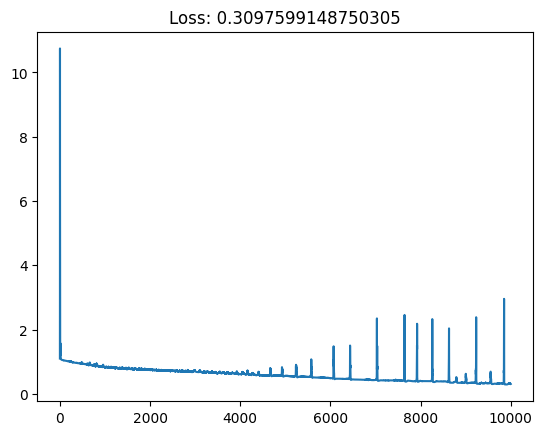

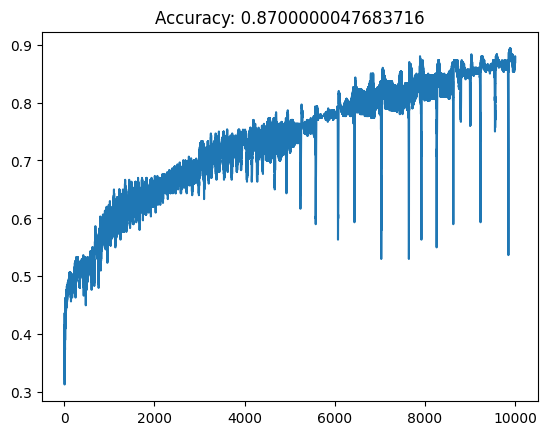

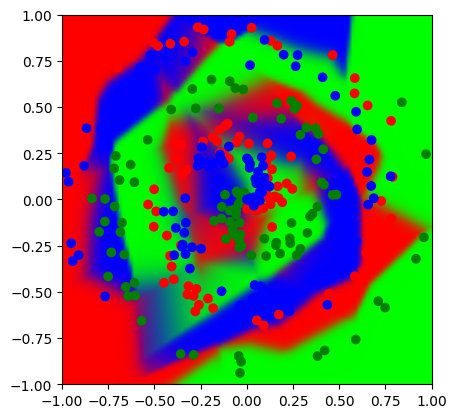

In [ ]:
# SOL EJ 31b

nnfs.init()
X, y = spiral_data(samples=100, classes=3)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int32)

#Implementa aquí la red neuronal
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_RMSprop(learning_rate=0.02, decay=1e-5, rho=0.999)

# listas para almacenar la evolución de la loss y la precisión
loss = []
accuracy = []

# entrenamiento aleatorio
for _ in range(10000):
    # foward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    l = loss_activation.calculate(dense2.output, y)

    # calculamos la loss y la precisión
    loss.append(l)
    correct_predictions = torch.sum(torch.argmax(loss_activation.output, dim=1) == y)
    accuracy.append(correct_predictions / len(y))

    # backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # actualizamos los parametros
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

# mostramos la evolución de la loss y la precisión
plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()


#Este código a continuación te ayudará a visualizar los resultados de la red (asegúrate que el la lista 'model' contiene los mismo nombres para las distintas capas, y si no es así actualiza dicha variable con el naming usado)
model = [dense1, activation1, dense2, loss_activation]
num_points = 100
plot_prediction_performance(model, X, y, num_points)

# la primera prueba no mejora los resultados del ejercicio anterior, se queda en un error del 0.7
# y una precisión de 0.7 también.
# con learning_rate=0.02, decay=1e-5, rho=0.999 los reesultados se acercan mucho a los del ejercicio
# anterior, pero no los supera. Esto puede ser por cualquier cosa, desde la semilla, al numero limitado
# de puntos, o a la simpleza del problema.

## Ejercicio 32: Adam

 - **32.a** Partiendo de la clase que implementaste en el ejercicio anterior, programa una nueva clase llamada ```Optimizer_Adam``` que implemente este optimizador. Adam añade a RMSProp el mecanismo de momentum ($\beta_1$). También añade además un mecanismo de corrección de sesgo, dividiendo tanto el momentum como el caché por $1-\beta_1^{step}$.

In [15]:
# SOL EJ 32c

# La red no aprende nada, porque el optimizador está mal implementado.
# para solucionarlo, basta con mover donde se actualiza el cache de los pesos y los biases
# Antes estaba después de actualizar los pesos y los biases, y ahora está antes.
# De la forma anterior, en la primera iteración, el weight_cache y el bias_cache en su versión corregida valian 0,
# lo que hacía que los pesos y los biases se disparasen, y la loss se fuera a 10.
# ahora ya eso no ocurre, pues los caches valen en la primera iter:
# (1 - self.beta_2) * layer.dweights**2
# y cuando se corrigen valen:
# (1 - self.beta_2) * layer.dweights**2 / (1 - self.beta_2 ** (0 + 1)) = layer.dweights**2

# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1  # momentum, and for the correction described above
        self.beta_2 = beta_2  # rename the old rho of RMSProp -> used for the cache

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate / (1 + self.decay * self.iterations)

    def update_params(self, layer):

        # If layer does not contain cache arrays, create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = torch.zeros_like(layer.weights)
            layer.weight_cache = torch.zeros_like(layer.weights)
            layer.bias_momentums = torch.zeros_like(layer.biases)
            layer.bias_cache = torch.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        # Get corrected momentum and cache (self.iteration is 0 at first pass, and we need to start with 1 here) -> so divide by (1 - self.beta_1 ** (self.iterations + 1))
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization with square-rooted cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (torch.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (torch.sqrt(bias_cache_corrected) + self.epsilon)

        
    def post_update_params(self):
        self.iterations += 1

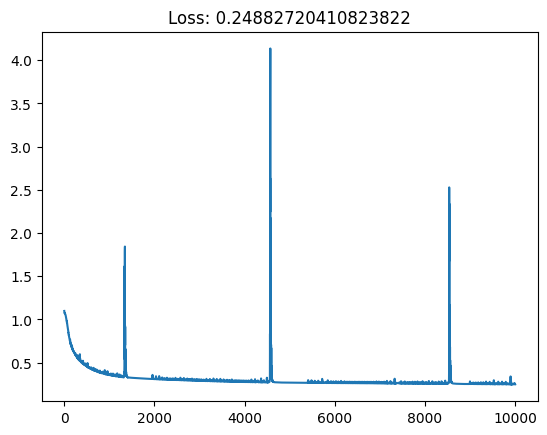

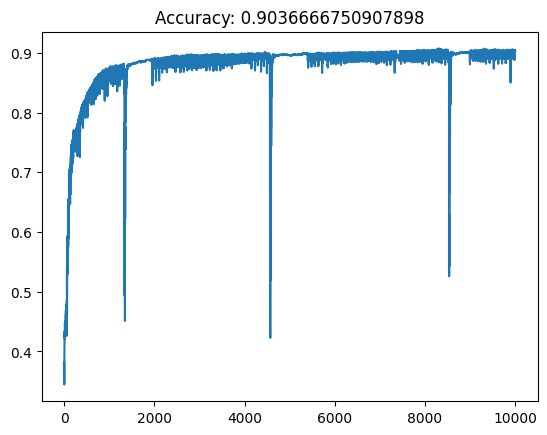

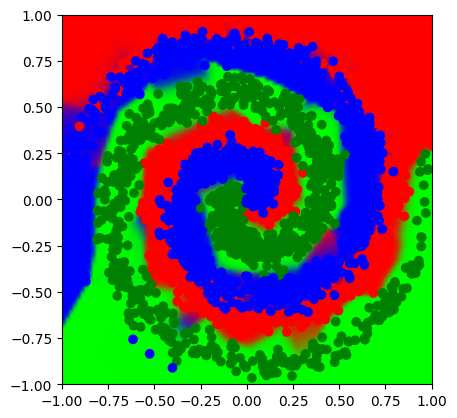

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X, y = spiral_data(samples=1000, classes=3)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int32)

#Implementa aquí la red neuronal
dense1 = Layer_Dense(2,64, device=device)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3, device=device)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy(device=device)
optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)

# listas para almacenar la evolución de la loss y la precisión
loss = []
accuracy = []

# entrenamiento aleatorio
for _ in range(10000):
    # foward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    l = loss_activation.calculate(dense2.output, y)

    # calculamos la loss y la precisión
    loss.append(l)
    correct_predictions = torch.sum(torch.argmax(loss_activation.output, dim=1) == y)
    accuracy.append(correct_predictions / len(y))

    # backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # actualizamos los parametros
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

# mostramos la evolución de la loss y la precisión
plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()


#Este código a continuación te ayudará a visualizar los resultados de la red (asegúrate que el la lista 'model' contiene los mismo nombres para las distintas capas, y si no es así actualiza dicha variable con el naming usado)
model = [dense1, activation1, dense2, loss_activation]
num_points = 100
plot_prediction_performance(model, X, y, num_points)

# Ahora funciona a la perfección, y los resultados son los mejores de todos los optimizadores.